<a href="https://colab.research.google.com/github/dhirajwagh1612/dhirajwagh1612/blob/main/Computer_Vision_GL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DOMAIN**:  Botanical Research

**CONTEXT**: University X is currently undergoing some research involving understanding the characteristics of plant and plant seedlings at various  stages  of  growth.  They  already  have  have  invested  on  curating  sample  images.  They  require  an  automation  which  can  create  a classifier capable of determining a plant's species from a photo.

**DATA DESCRIPTION:** The dataset comprises of images from 12 plant species. Source: https://www.kaggle.com/c/plant-seedlings-classification/data

**PROJECT OBJECTIVE:** To create a classifier capable of determining a plant's species from a photo.

**Steps and tasks:**

In [ ]:
#cd "/content/drive/MyDrive/datasets/GL_kaggle"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import svm, metrics
from natsort import natsorted
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV

In [ ]:
train_path = "/content/drive/MyDrive/datasets/GL_kaggle/plant-seedlings-classification.zip"

In [ ]:
from zipfile import ZipFile
with ZipFile(train_path, 'r') as zip:
  zip.extractall('./train')

In [ ]:
cd "/content/drive/MyDrive/dataset/"

/content/drive/MyDrive/dataset


In [ ]:
paths = glob.glob("train/*")
label_names = [os.path.split(x)[-1] for x in paths]

print("Total labels: {}".format(len(label_names)))
print("Labels: {}".format(label_names))

Total labels: 12
Labels: ['Scentless Mayweed', 'Black-grass', 'Loose Silky-bent', 'Common wheat', 'Fat Hen', 'Common Chickweed', 'Shepherds Purse', 'Charlock', 'Cleavers', 'Maize', 'Small-flowered Cranesbill', 'Sugar beet']


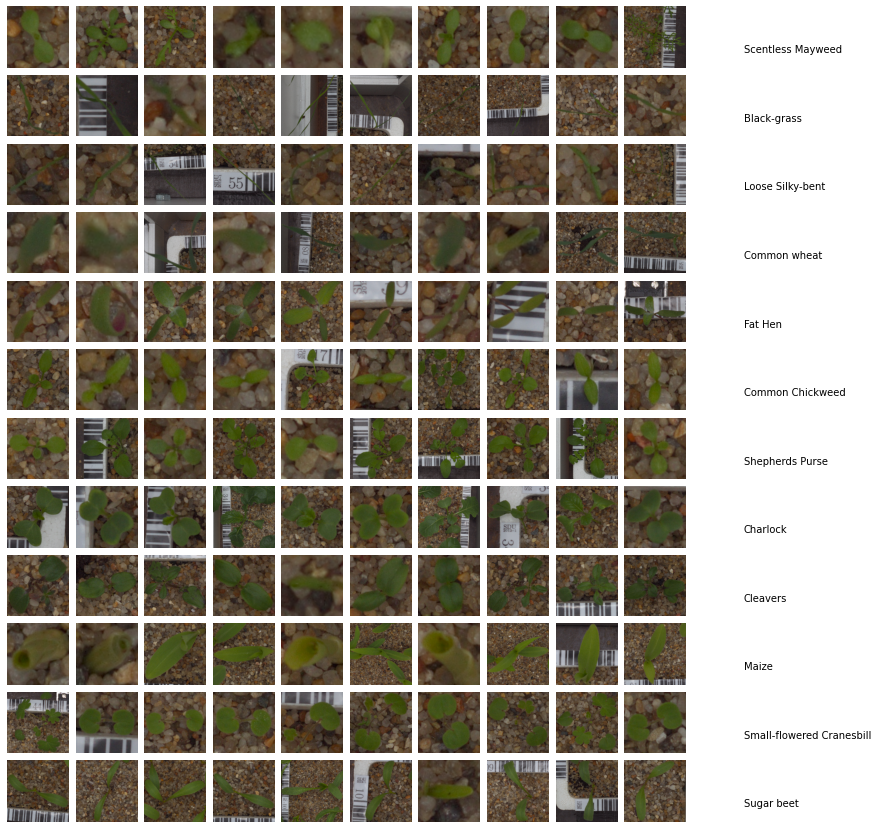

In [ ]:
fig = plt.figure(1, (20, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(12, 10), axes_pad=0.1)

n_img_class = []
counter = 0
for idx, label in enumerate(label_names):
    paths = glob.glob(os.path.join("train", label, "*.png"))
    n_img_class.append([label, len(paths)])
    perm = np.random.choice(len(paths), size=10)

    title = True
    for ii in perm:
        ax = grid[counter]
        if title:
            ax.text(1800, 105, label, verticalalignment="center")
            title = False
        img = cv2.imread(paths[ii])
        img = cv2.resize(img, (150, 150))
        ax.axis("off")
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        counter += 1
        
plt.show()

In [ ]:
img.shape

(150, 150, 3)

In [ ]:
#save the path into variable to use it easily next times.
TRAIN_FOLDER= "train"

In [ ]:
from glob import glob
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAIN_FOLDER):
    class_folder_path = os.path.join(TRAIN_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missing value ignore it
          missing += 1
          continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [ ]:
len(images)

4755

In [ ]:
# resize image
def resize_images(img):

  img = np.array(img).astype(np.uint8)
  #print(img.dtype)
  res = cv2.resize(img,(256,256), interpolation = cv2.INTER_CUBIC)
  return res

#save resized images into images.
images = [resize_images(img) for img in images]

In [ ]:
images[0].shape

(256, 256, 3)

In [ ]:
#see number of images in each label
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (4755, 256, 256, 3)
classes shape:  (4755,)


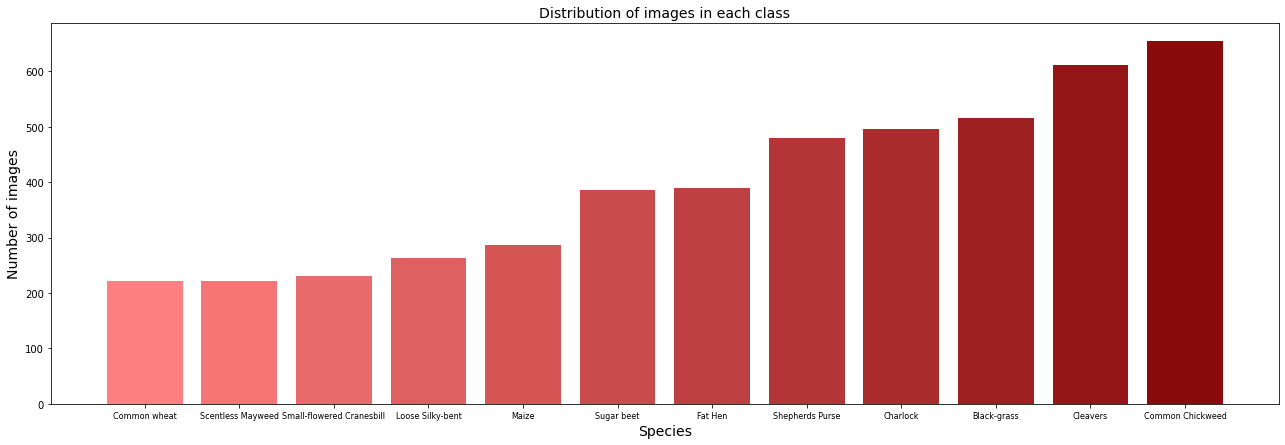

In [ ]:
values =[]
labels=[]
for label in set(classes):
  values.append(len(images[classes == label]))
  labels.append(label)

values.sort()

code=np.arange(0,13,1)
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values, color=color_map(data_normalizer(code)))
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 10)
plt.xlabel("Species", fontsize = 14)
plt.ylabel("Number of images", fontsize = 14)
plt.title("Distribution of images in each class", fontsize=14)
plt.show()

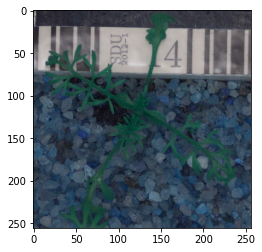

In [ ]:
plt.imshow(images[50])

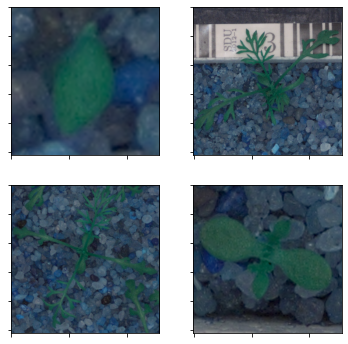

In [ ]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("Scentless Mayweed")

In [ ]:
#!ls "train/Scentless Mayweed" 1300c3cd9.png

img = cv2.imread("train/Scentless Mayweed/1300c3cd9.png")

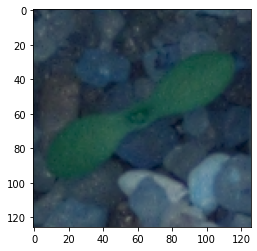

In [ ]:
plt.imshow(img)

In [ ]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

In [ ]:
def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

In [ ]:
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [ ]:
# Combining all functions

def preprocess(img):
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

for indx, image in enumerate(images):
  try:
    images[indx] = preprocess(image)
      
  except:
    print(indx)
    continue

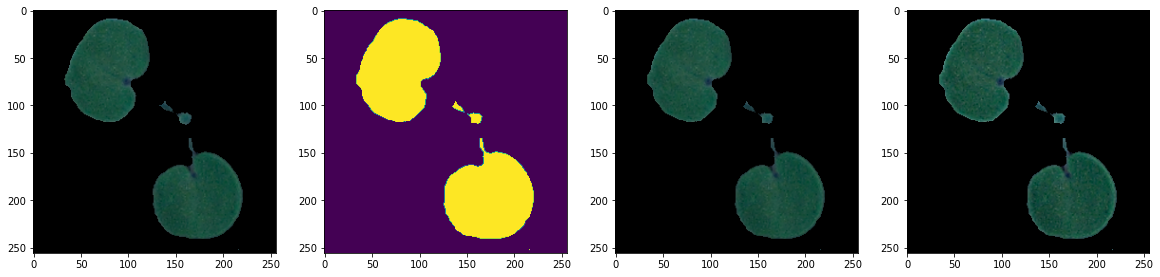

In [ ]:
images = np.array(images)
classes = np.array(classes)
image = images[classes == "Small-flowered Cranesbill"][40]

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

In [ ]:
model_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss','Predicted Class'])

In [ ]:
number_of_columns = images[1].shape[0] * images[1].shape[1]
print(number_of_columns)

65536


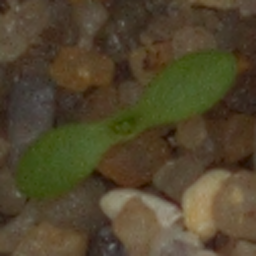

The shape of image to be predicted is:'(126, 126, 3)'
The shape of image to be predicted after expanding the dimensions is:'(1, 256, 256, 3)'


In [ ]:
from google.colab.patches import cv2_imshow

img_pred = cv2.imread('train/Scentless Mayweed/1300c3cd9.png')
img_pred_resize = cv2.resize(img_pred,(256,256), interpolation = cv2.INTER_CUBIC)
cv2_imshow(img_pred_resize)
img_predict = np.expand_dims(img_pred_resize, axis=0)
print(f"The shape of image to be predicted is:'{img_pred.shape}'")
print(f"The shape of image to be predicted after expanding the dimensions is:'{img_predict.shape}'")

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(classes)

num_classes = len(np.unique(y))
num_classes

12

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

In [ ]:
random_seed = 2
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [ ]:
print(f"#### Shapes of Train, Test and Validation sets are: {X_train.shape},{X_test.shape},{X_val.shape}")

#### Shapes of Train, Test and Validation sets are: (3328, 256, 256, 3),(713, 256, 256, 3),(714, 256, 256, 3)


In [ ]:
print(f"#### Shapes of Train, Test and Validation sets of Target are: {y_train.shape},{y_test.shape},{y_val.shape}")

#### Shapes of Train, Test and Validation sets of Target are: (3328,),(713,),(714,)


In [ ]:
def flatten(X):
  Xr, Xg, Xb = [],[],[]
  for samples in X:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

In [ ]:
X_train_r, X_train_g, X_train_b = flatten(X_train)
X_test_r, X_test_g, X_test_b = flatten(X_test)
X_val_r, X_val_g, X_val_b = flatten(X_val)

In [ ]:
X_train_r.shape, X_train_g.shape, X_train_b.shape,
X_test_r.shape, X_test_g.shape, X_test_b.shape,
X_val_r.shape, X_val_g.shape, X_val_b.shape

((714, 65536), (714, 65536), (714, 65536))

In [ ]:
n_components = 500
X_train_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_r)
X_train_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_g)
X_train_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_b)

X_test_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_r)
X_test_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_g)
X_test_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_b)

X_val_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_r)
X_val_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_g)
X_val_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_b)

In [ ]:
Xr_train_pca = X_train_pca_r.transform(X_train_r)
Xg_train_pca = X_train_pca_g.transform(X_train_g)
Xb_train_pca = X_train_pca_b.transform(X_train_b)

Xr_test_pca = X_test_pca_r.transform(X_test_r)
Xg_test_pca = X_test_pca_g.transform(X_test_g)
Xb_test_pca = X_test_pca_b.transform(X_test_b)

Xr_val_pca = X_val_pca_r.transform(X_val_r)
Xg_val_pca = X_val_pca_g.transform(X_val_g)
Xb_val_pca = X_val_pca_b.transform(X_val_b)

In [ ]:
X_train_pca_r.explained_variance_ratio_.sum(), X_train_pca_g.explained_variance_ratio_.sum(), X_train_pca_b.explained_variance_ratio_.sum(),
X_test_pca_r.explained_variance_ratio_.sum(), X_test_pca_g.explained_variance_ratio_.sum(), X_test_pca_b.explained_variance_ratio_.sum(),
X_val_pca_r.explained_variance_ratio_.sum(), X_val_pca_g.explained_variance_ratio_.sum(), X_val_pca_b.explained_variance_ratio_.sum()

(0.9568056365337254, 0.9782242016557026, 0.970373915404827)

In [ ]:
X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)
X_val_pca = np.concatenate([Xr_val_pca,Xg_val_pca,Xb_val_pca], axis=1)

In [ ]:
X_train_pca.shape, y_train.shape,
X_test_pca.shape, y_test.shape,
X_val_pca.shape, y_val.shape

((714, 1500), (714,))

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = SVC()
clf = GridSearchCV(svc, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=10)

In [ ]:
X_train.shape[0]

3328

In [ ]:
y_train.shape[0]

3328

In [ ]:
svm_score = clf.score(X_val_pca, y_val)

In [ ]:
y_pred = clf.predict(X_test_pca)
svm_accuracy = metrics.accuracy_score(y_test, y_pred)

In [ ]:
pred_img = np.squeeze(img_predict, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)

In [ ]:
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

In [ ]:
model_performance = model_performance.append({'Model':'SVM',
                                              'Accuracy': svm_accuracy,
                                              'Loss': 'NA',
                                              #'Predicted Class': pred_svm                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.276297,NA,NaN


In [ ]:
import itertools

import tensorflow
from tensorflow.keras.layers import Dense, Dropout, InputLayer, BatchNormalization, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
#from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam

In [ ]:
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y2 = enc.fit_transform(classes)

In [ ]:
y2[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)

In [ ]:
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [ ]:
X_train.shape,y_train.shape

((3328, 256, 256, 3), (3328, 12))

In [ ]:
num_classes = len(np.unique(y_train))
num_classes

2

In [ ]:
def ann_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  # batch_size = None

  model = Sequential()

  model.add(InputLayer(input_shape=(height, width, num_channels)))

  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))

  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))
  opt = tensorflow.keras.optimizers.Adam(lr=0.000001)
  model.compile(optimizer = opt, loss = loss, metrics = metrics)

  model.summary()
  return model

In [ ]:
ann = ann_model(256,256,3,12)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 batch_normalization (BatchN  (None, 196608)           786432    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              201327616 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 512)               5

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = ann.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val),
                  batch_size = 100)

Epoch 1/50
34/34 [==============================] - 15s 265ms/step - loss: 2.8714 - accuracy: 0.1584 - val_loss: 3.2509 - val_accuracy: 0.1555
Epoch 2/50
34/34 [==============================] - 9s 252ms/step - loss: 2.2479 - accuracy: 0.2855 - val_loss: 2.3114 - val_accuracy: 0.2787
Epoch 3/50
34/34 [==============================] - 9s 252ms/step - loss: 1.9727 - accuracy: 0.3510 - val_loss: 1.9229 - val_accuracy: 0.3866
Epoch 4/50
34/34 [==============================] - 9s 252ms/step - loss: 1.7637 - accuracy: 0.4062 - val_loss: 1.7011 - val_accuracy: 0.4552
Epoch 5/50
34/34 [==============================] - 9s 251ms/step - loss: 1.6407 - accuracy: 0.4513 - val_loss: 1.5665 - val_accuracy: 0.4986
Epoch 6/50
34/34 [==============================] - 9s 252ms/step - loss: 1.4736 - accuracy: 0.5051 - val_loss: 1.4671 - val_accuracy: 0.5336
Epoch 7/50
34/34 [==============================] - 9s 253ms/step - loss: 1.3604 - accuracy: 0.5577 - val_loss: 1.4012 - val_accuracy: 0.5518
Epoch

In [ ]:
ann_loss, ann_accuracy = ann.evaluate(X_test, y_test, verbose=1)
print('Test loss:', ann_loss)
print('Test accuracy:', ann_accuracy)

23/23 [==============================] - 1s 32ms/step - loss: 1.1057 - accuracy: 0.6438
Test loss: 1.105652928352356
Test accuracy: 0.6437587738037109


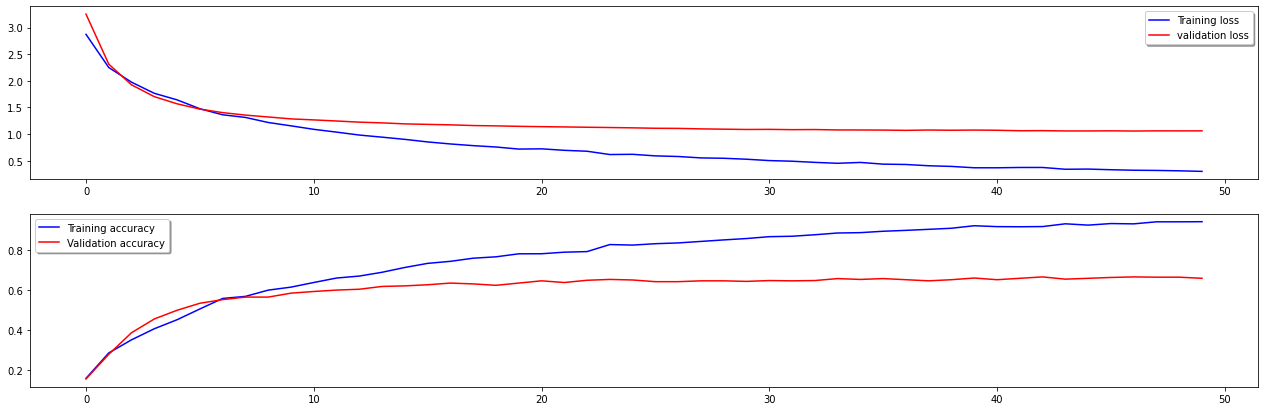

In [ ]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
ann_predict = np.argmax(ann.predict(img_predict))

In [ ]:
print('The predicted flower is with label:', ann_predict)

The predicted flower is with label: 1


In [ ]:
model_performance = model_performance.append({'Model':'ANN',
                                              'Accuracy': ann_accuracy,
                                              'Loss': ann_loss,
                                              'Predicted Class': ann_predict                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.276297,NA,NaN
1,ANN,0.643759,1.105653,1.0


In [ ]:
def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.2))


  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.4))



  model.add(GlobalMaxPooling2D())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = "softmax"))

  optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  model.summary()
  return model

In [ ]:
cnn = cnn_model(256,256,3,12)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      2432      
                                                                 
 conv2d_7 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 128, 128, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 64)      36928     
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val),
                  batch_size = 100)

Epoch 1/50
34/34 [==============================] - 96s 2s/step - loss: 3.4769 - accuracy: 0.1463 - val_loss: 2.3947 - val_accuracy: 0.1527
Epoch 2/50
34/34 [==============================] - 60s 2s/step - loss: 2.4355 - accuracy: 0.1737 - val_loss: 2.4075 - val_accuracy: 0.1134
Epoch 3/50
34/34 [==============================] - 60s 2s/step - loss: 2.3831 - accuracy: 0.1980 - val_loss: 2.4370 - val_accuracy: 0.2003
Epoch 4/50
34/34 [==============================] - 60s 2s/step - loss: 2.3092 - accuracy: 0.2470 - val_loss: 2.2162 - val_accuracy: 0.2689
Epoch 5/50
34/34 [==============================] - 59s 2s/step - loss: 2.1743 - accuracy: 0.2677 - val_loss: 2.1151 - val_accuracy: 0.2577
Epoch 6/50
34/34 [==============================] - 60s 2s/step - loss: 2.0771 - accuracy: 0.2752 - val_loss: 2.1005 - val_accuracy: 0.3669
Epoch 7/50
34/34 [==============================] - 60s 2s/step - loss: 2.0700 - accuracy: 0.2993 - val_loss: 2.1216 - val_accuracy: 0.3866
Epoch 8/50
34/34 [==

In [ ]:
cnn_loss, cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss)
print('Test accuracy:', cnn_accuracy)

23/23 [==============================] - 9s 237ms/step - loss: 0.6480 - accuracy: 0.7882
Test loss: 0.6480051279067993
Test accuracy: 0.7882187962532043


In [ ]:
cnn_predict = np.argmax(cnn.predict(img_predict))

In [ ]:
model_performance = model_performance.append({'Model':'CNN',
                                              'Accuracy': cnn_accuracy,
                                              'Loss': cnn_loss,
                                              'Predicted Class': cnn_predict                                      
                                              }, ignore_index=True)

model_performance

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.276297,NA,NaN
1,ANN,0.643759,1.105653,1.0
2,CNN,0.788219,0.648005,7.0


In [ ]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 30
batch_size = 38

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

NameError: ignored

In [ ]:
# X_train, X_test, y_train, y_test
history = cnn.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

In [ ]:
cnn_loss_aug, cnn_accuracy_aug = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss_aug)
print('Test accuracy:', cnn_accuracy_aug)

In [ ]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [ ]:
cnn_predict_aug = np.argmax(cnn.predict(img_predict))

In [ ]:
print('The predicted flower is with label:', cnn_predict)

In [ ]:
model_performance = model_performance.append({'Model':'CNN with Data Augmentaion',
                                              'Accuracy': cnn_accuracy_aug,
                                              'Loss': cnn_loss_aug,
                                              'Predicted Class': cnn_predict_aug                                      
                                              }, ignore_index=True)

model_performance

**Part B**

**DOMAIN:** Botanical Research

**CONTEXT:** University X is currently undergoing some research involving understanding the characteristics of flowers. They already have
have invested on curating sample images. They require an automation which can create a classifier capable of determining a flower’s
species from a photo.

**DATA DESCRIPTION:** The dataset comprises of images from 17 plant species.

**PROJECT OBJECTIVE:** To experiment with various approaches to train an image classifier to predict type of flower from the image.

**Steps and tasks:**

1. Import and Understand the data

      A. Import and read oxflower17 dataset from tflearn and split into X and Y while loading.

In [16]:
import cv2
import os
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import svm, metrics
from natsort import natsorted
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
# from sklearn.grid_search import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV

In [17]:
pip install tflearn

     |████████████████████████████████| 107 kB 9.0 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=1050b015158735394adb76b8c5bbfb7f002bb4a773014406b72569e451568b49
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn


In [18]:
import tflearn.datasets.oxflower17 as oxflower17
from sklearn.model_selection import train_test_split
X, y = oxflower17.load_data(resize_pics=(224,224))

Instructions for updating:
non-resource variables are not supported in the long term


100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


In [19]:
X[0].min(), X[0].max()

(0.0, 1.0)

In [20]:
X.shape, y.shape

((1360, 224, 224, 3), (1360,))

Text(0.5, 1.0, 'Displaying a random image')

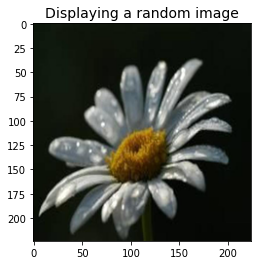

In [21]:
plt.imshow(X[50])
plt.title("Displaying a random image", fontsize=14)

In [22]:
print("Total labels: {}".format(len(np.unique(y))))
print("Labels: {}".format(y))

Total labels: 17
Labels: [ 5  9 11 ... 10  8  1]


IndexError: ignored

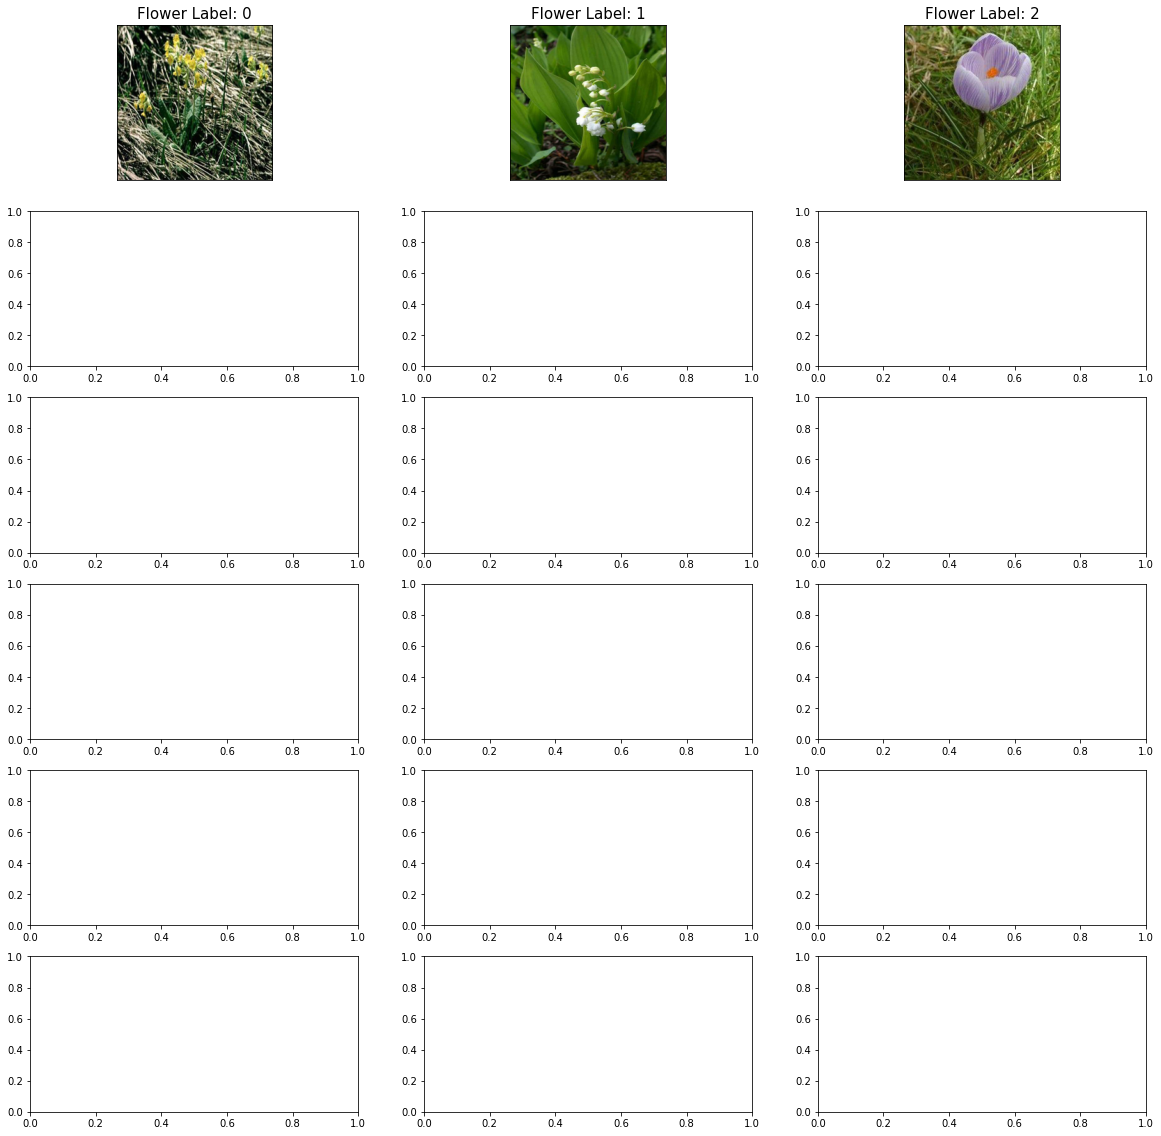

In [24]:
cols = 3
rows = int(np.ceil(len(np.unique(y))/cols))

fig, ax = plt.subplots(rows, cols, figsize=(20,20))
for i in np.unique(y):
  col = i % 5
  row = int(i/5)

  ax[row][col].imshow(X[i])
  ax[row][col].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
  ax[row][col].set_title(f"Flower Label: {i}",{'fontsize':15})
plt.show() 

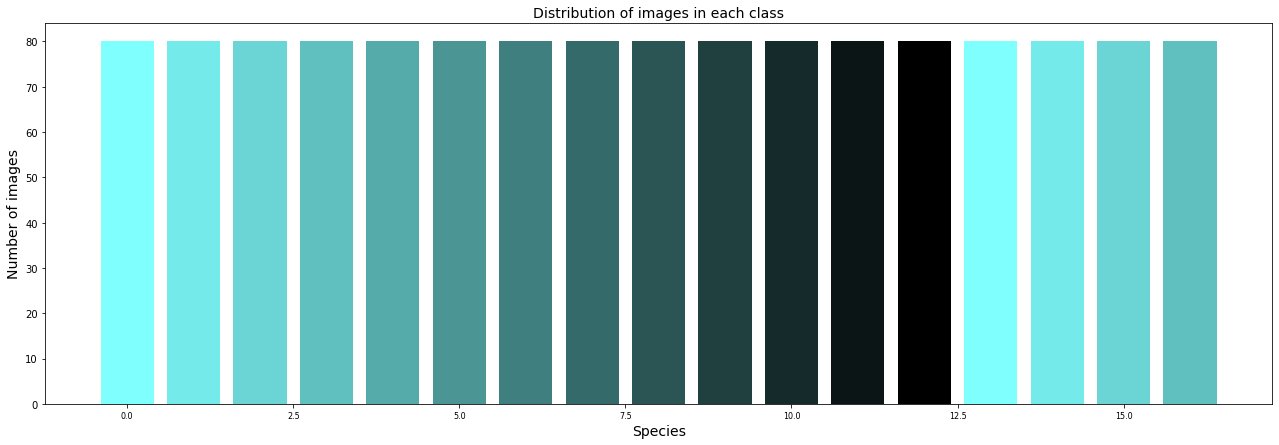

In [25]:
values =[]
labels=[]
for label in set(y):
  values.append(len(X[y == label]))
  labels.append(label)

values.sort()

code=np.arange(0,13,1)
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 0, 0.5),
                (1.0, 0, .5)],
        "green": [(0, 0.5, 1.0),
                  (1.0, 0, 0)],
        "blue": [(0, 1.0, 1.0),
                 (1.0, 0, 0)]
    }
)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values, color=color_map(data_normalizer(code)))
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 10)
plt.xlabel("Species", fontsize = 14)
plt.ylabel("Number of images", fontsize = 14)
plt.title("Distribution of images in each class", fontsize=14)
plt.show()

In [26]:
#Image Preprocessing

In [27]:
#Converting images from RGB to HSV and applying mophological transformations

In [28]:
#Applying Segmentation

In [29]:
def segment_plant(image):
    output = cv2.bitwise_and(image, image)
    return output

In [30]:
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [ ]:
def preprocess(img):
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

for indx, image in enumerate(images):
  try:
    images[indx] = preprocess(image)
      
  except:
    print(indx)
    continue

In [32]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


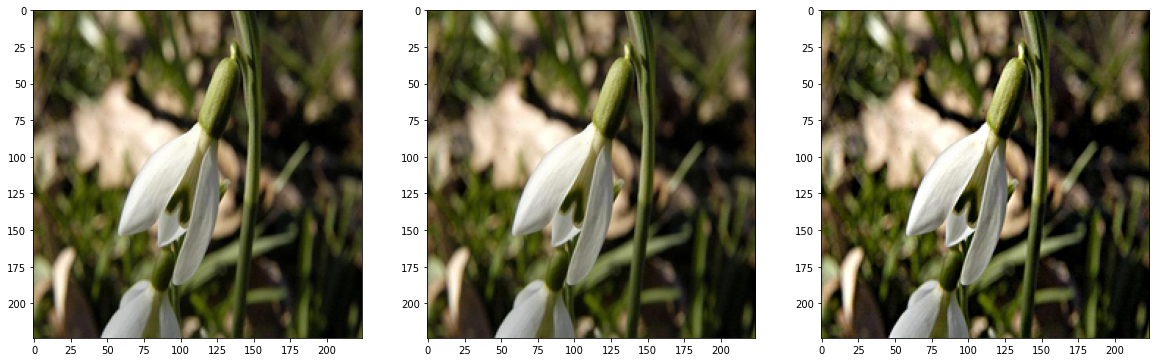

In [33]:
images = np.array(X)
classes = np.array(y)
image = X[25]


image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_segmented)
axs[2].imshow(image_sharpen)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

In [35]:
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

In [36]:
print(f"#### Shapes of Train, Test and Validation sets are: {X_train.shape},{X_test.shape},{X_val.shape}")

#### Shapes of Train, Test and Validation sets are: (952, 224, 224, 3),(204, 224, 224, 3),(204, 224, 224, 3)


In [38]:
print(f"#### Shapes of Train, Test and Validation sets of Target are: {y_train.shape},{y_test.shape},{y_val.shape}")

#### Shapes of Train, Test and Validation sets of Target are: (952,),(204,),(204,)


In [39]:
num_classes = len(np.unique(y_train))
num_classes

17

In [40]:
number_of_columns = images[1].shape[0] * images[1].shape[1]
print(number_of_columns)

50176


In [41]:
import pandas as pd

In [42]:
model_performance_b = pd.DataFrame(columns=['Model', 'Accuracy', 'Loss','Predicted Class'])

In [43]:
def flatten(X):
  Xr, Xg, Xb = [],[],[]
  for samples in X:
    r, g, b = cv2.split(samples)
    Xr.append(r.flatten())
    Xg.append(g.flatten())
    Xb.append(b.flatten())
  Xr = np.array(Xr)
  Xg = np.array(Xg)
  Xb = np.array(Xb)
  return (Xr, Xg, Xb)

In [44]:
X_train_r, X_train_g, X_train_b = flatten(X_train)
X_test_r, X_test_g, X_test_b = flatten(X_test)
X_val_r, X_val_g, X_val_b = flatten(X_val)

In [45]:
X_train_r.shape, X_train_g.shape, X_train_b.shape,
X_test_r.shape, X_test_g.shape, X_test_b.shape,
X_val_r.shape, X_val_g.shape, X_val_b.shape

((204, 50176), (204, 50176), (204, 50176))

In [46]:
from sklearn.decomposition import PCA as RandomizedPCA

In [47]:
n_components = 150
X_train_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_r)
X_train_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_g)
X_train_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train_b)

X_test_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_r)
X_test_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_g)
X_test_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_test_b)

X_val_pca_r = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_r)
X_val_pca_g = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_g)
X_val_pca_b = RandomizedPCA(n_components=n_components, whiten=True).fit(X_val_b)

In [48]:
Xr_train_pca = X_train_pca_r.transform(X_train_r)
Xg_train_pca = X_train_pca_g.transform(X_train_g)
Xb_train_pca = X_train_pca_b.transform(X_train_b)

Xr_test_pca = X_test_pca_r.transform(X_test_r)
Xg_test_pca = X_test_pca_g.transform(X_test_g)
Xb_test_pca = X_test_pca_b.transform(X_test_b)

Xr_val_pca = X_val_pca_r.transform(X_val_r)
Xg_val_pca = X_val_pca_g.transform(X_val_g)
Xb_val_pca = X_val_pca_b.transform(X_val_b)

In [49]:
X_train_pca_r.explained_variance_ratio_.sum(), X_train_pca_g.explained_variance_ratio_.sum(), X_train_pca_b.explained_variance_ratio_.sum(),
X_test_pca_r.explained_variance_ratio_.sum(), X_test_pca_g.explained_variance_ratio_.sum(), X_test_pca_b.explained_variance_ratio_.sum(),
X_val_pca_r.explained_variance_ratio_.sum(), X_val_pca_g.explained_variance_ratio_.sum(), X_val_pca_b.explained_variance_ratio_.sum()

(0.9646927, 0.96376455, 0.97480017)

In [50]:
X_train_pca = np.concatenate([Xr_train_pca,Xg_train_pca,Xb_train_pca], axis=1)
X_test_pca = np.concatenate([Xr_test_pca,Xg_test_pca,Xb_test_pca], axis=1)
X_val_pca = np.concatenate([Xr_val_pca,Xg_val_pca,Xb_val_pca], axis=1)

In [51]:
X_train_pca.shape, y_train.shape,
X_test_pca.shape, y_test.shape,
X_val_pca.shape, y_val.shape

((204, 450), (204,))

In [52]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = SVC()
clf = GridSearchCV(svc, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             verbose=10)

In [53]:
y_pred = clf.predict(X_test_pca)
svm_accuracy = metrics.accuracy_score(y_test, y_pred)

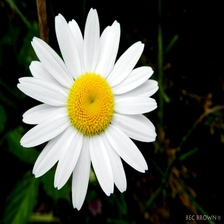

The shape of image to be predicted is:'(224, 224, 3)'
The shape of image to be predicted after expanding the dimensions is:'(1, 224, 224, 3)'


In [54]:
from google.colab.patches import cv2_imshow

img_pred = cv2.imread('/content/Prediction.jpg')
img_pred_resize = cv2.resize(img_pred,(224,224), interpolation = cv2.INTER_CUBIC)
cv2_imshow(img_pred_resize)
img_predict = np.expand_dims(img_pred_resize, axis=0)
print(f"The shape of image to be predicted is:'{img_pred.shape}'")
print(f"The shape of image to be predicted after expanding the dimensions is:'{img_predict.shape}'")

In [55]:
pred_img = np.squeeze(img_predict, axis=0)
X_pred_r, X_pred_g, X_pred_b = cv2.split(pred_img)

In [56]:
X_pred_pca_r = X_train_pca_r.transform(np.expand_dims(X_pred_r.flatten(), axis=0))
X_pred_pca_g = X_train_pca_g.transform(np.expand_dims(X_pred_g.flatten(), axis=0))
X_pred_pca_b = X_train_pca_b.transform(np.expand_dims(X_pred_b.flatten(), axis=0))

X_pred_pca = np.concatenate([X_pred_pca_r,X_pred_pca_g,X_pred_pca_b], axis=1)

In [57]:
pred_svm = clf.predict(X_pred_pca)[0]

print(f"The predicted label is:'{pred_svm}'")

The predicted label is:'1'


In [58]:
model_performance_b = model_performance_b.append({'Model':'SVM',
                                              'Accuracy': svm_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_svm                                      
                                              }, ignore_index=True)

model_performance_b

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.083333,NA,1


In [59]:
param_grid=[
            {'n_estimators':[100,200],
             'min_samples_leaf':[2,3]}
           ]
rf = RandomForestClassifier()
clf = GridSearchCV(rf, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'min_samples_leaf': [2, 3],
                          'n_estimators': [100, 200]}],
             verbose=10)

In [60]:
rf_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
rf_accuracy = metrics.accuracy_score(y_test, y_pred)
pred_rf = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_rf}'")

The predicted label is:'2'


In [61]:
model_performance_b = model_performance_b.append({'Model':'RF',
                                              'Accuracy': rf_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_rf                                      
                                              }, ignore_index=True)

model_performance_b

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.083333,NA,1
1,RF,0.147059,NA,2


In [62]:
from sklearn.tree import DecisionTreeClassifier
param_grid = [
              {'max_leaf_nodes': list(range(2, 100)), 
               'min_samples_split': [2, 3, 4]}
              ]
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, param_grid, verbose=10, n_jobs=-1)
clf.fit(X_train_pca,y_train)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid=[{'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                             13, 14, 15, 16, 17, 18, 19, 20, 21,
                                             22, 23, 24, 25, 26, 27, 28, 29, 30,
                                             31, ...],
                          'min_samples_split': [2, 3, 4]}],
             verbose=10)

In [63]:
dt_score = clf.score(X_val_pca, y_val)
y_pred = clf.predict(X_test_pca)
dt_accuracy = metrics.accuracy_score(y_test, y_pred)
pred_dt = clf.predict(X_pred_pca)[0]
print(f"The predicted label is:'{pred_dt}'")

The predicted label is:'2'


In [64]:
model_performance_b = model_performance_b.append({'Model':'DT',
                                              'Accuracy': dt_accuracy,
                                              'Loss': 'NA',
                                              'Predicted Class': pred_dt                                      
                                              }, ignore_index=True)

model_performance_b

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.083333,NA,1
1,RF,0.147059,NA,2
2,DT,0.049020,NA,2


In [65]:
#Classification using Artificial Neural Network (ANN)

In [66]:
import tensorflow as tf
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

In [67]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.3, random_state=50)

In [69]:
random_seed = 2
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=random_seed)

In [70]:
X_train.shape,y_train.shape

((952, 224, 224, 3), (952,))

In [71]:
from tensorflow import keras

In [72]:
def ann_model(height, width, num_channels, num_classes, loss='sparse_categorical_crossentropy', metrics=['accuracy']):
  # batch_size = None

  model = keras.Sequential()

  model.add(tf.keras.layers.InputLayer(input_shape=(height, width, num_channels)))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(1024, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(num_classes, activation = "softmax"))
  opt = tf.keras.optimizers.Adam(lr=0.000001)
  model.compile(optimizer = opt, loss = loss, metrics = metrics)

  model.summary()
  return model

In [73]:
ann = ann_model(224,224,3,17)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 batch_normalization (BatchN  (None, 150528)           602112    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              154141696 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [74]:
history = ann.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val),
                  batch_size = 300)

Train on 952 samples, validate on 204 samples
Epoch 1/50
952/952 [==============================] - 3s 4ms/sample - loss: 3.5754 - acc: 0.0630 - val_loss: 2.9041 - val_acc: 0.0539
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


952/952 [==============================] - 1s 652us/sample - loss: 3.4169 - acc: 0.0840 - val_loss: 2.8754 - val_acc: 0.0490
Epoch 3/50
952/952 [==============================] - 1s 660us/sample - loss: 3.1557 - acc: 0.1019 - val_loss: 2.8482 - val_acc: 0.0490
Epoch 4/50
952/952 [==============================] - 1s 658us/sample - loss: 2.9426 - acc: 0.1429 - val_loss: 2.8241 - val_acc: 0.0490
Epoch 5/50
952/952 [==============================] - 1s 663us/sample - loss: 2.9136 - acc: 0.1691 - val_loss: 2.8030 - val_acc: 0.0539
Epoch 6/50
952/952 [==============================] - 1s 671us/sample - loss: 2.7593 - acc: 0.1691 - val_loss: 2.7853 - val_acc: 0.0539
Epoch 7/50
952/952 [==============================] - 1s 663us/sample - loss: 2.6769 - acc: 0.1943 - val_loss: 2.7714 - val_acc: 0.0637
Epoch 8/50
952/952 [==============================] - 1s 670us/sample - loss: 2.5382 - acc: 0.2332 - val_loss: 2.7569 - val_acc: 0.0882
Epoch 9/50
952/952 [==============================] - 1s 65

In [75]:
ann_loss, ann_accuracy = ann.evaluate(X_test, y_test, verbose=1)
print('Test loss:', ann_loss)
print('Test accuracy:', ann_accuracy)

Test loss: 2.153960375224843
Test accuracy: 0.36764705


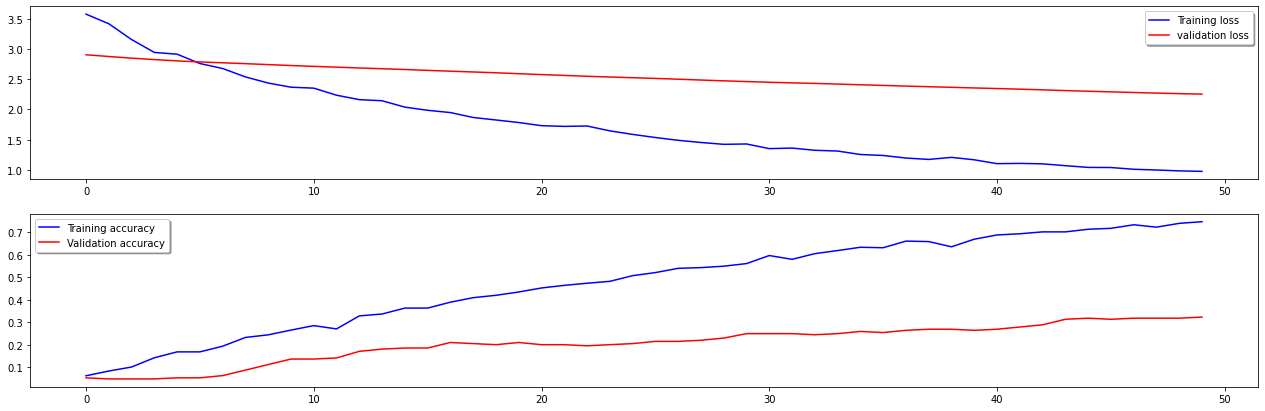

In [76]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [77]:
ann_predict = np.argmax(ann.predict(img_predict))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [78]:
print('The predicted flower is with label:', ann_predict)

The predicted flower is with label: 12


In [79]:
model_performance_b = model_performance_b.append({'Model':'ANN',
                                              'Accuracy': ann_accuracy,
                                              'Loss': ann_loss,
                                              'Predicted Class': ann_predict                                      
                                              }, ignore_index=True)

model_performance_b

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.083333,NA,1
1,RF,0.147059,NA,2
2,DT,0.049020,NA,2
3,ANN,0.367647,2.15396,12


In [80]:
# Classification using Convolution Neural Network (CNN)

In [81]:
def cnn_model(height, width, num_channels, num_classes, loss='sparse_categorical_crossentropy', metrics=['accuracy']):
  batch_size = None

  model = keras.Sequential()

  model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


  model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(0.2))


  model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                  activation ='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.3))

  model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                  activation ='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
  model.add(tf.keras.layers.Dropout(0.4))



  model.add(tf.keras.layers.GlobalMaxPooling2D())
  model.add(tf.keras.layers.Dense(256, activation = "relu"))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(num_classes, activation = "softmax"))

  opt = tf.keras.optimizers.Adam(lr=0.000001)
  model.compile(optimizer = opt, loss = loss, metrics = metrics)
  model.summary()
  return model

In [82]:
cnn = cnn_model(224,224,3,17)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [83]:
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 50, 
                  validation_data = (X_val,y_val),
                  batch_size = 100)

Train on 952 samples, validate on 204 samples
Epoch 1/50
952/952 [==============================] - ETA: 0s - loss: 2.8680 - acc: 0.0525

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


952/952 [==============================] - 26s 27ms/sample - loss: 2.8680 - acc: 0.0525 - val_loss: 2.8344 - val_acc: 0.0735
Epoch 2/50
952/952 [==============================] - 5s 5ms/sample - loss: 2.8588 - acc: 0.0609 - val_loss: 2.8344 - val_acc: 0.0735
Epoch 3/50
952/952 [==============================] - 5s 5ms/sample - loss: 2.8705 - acc: 0.0525 - val_loss: 2.8343 - val_acc: 0.0686
Epoch 4/50
952/952 [==============================] - 5s 5ms/sample - loss: 2.8591 - acc: 0.0578 - val_loss: 2.8343 - val_acc: 0.0686
Epoch 5/50
952/952 [==============================] - 5s 5ms/sample - loss: 2.8648 - acc: 0.0483 - val_loss: 2.8342 - val_acc: 0.0686
Epoch 6/50
952/952 [==============================] - 5s 5ms/sample - loss: 2.8678 - acc: 0.0473 - val_loss: 2.8342 - val_acc: 0.0686
Epoch 7/50
952/952 [==============================] - 5s 5ms/sample - loss: 2.8642 - acc: 0.0567 - val_loss: 2.8341 - val_acc: 0.0686
Epoch 8/50
952/952 [==============================] - 5s 5ms/sample - l

In [84]:
cnn_loss, cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss)
print('Test accuracy:', cnn_accuracy)

Test loss: 2.8296246762369193
Test accuracy: 0.073529415


In [85]:
cnn_predict = np.argmax(cnn.predict(img_predict))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [86]:
model_performance_b = model_performance_b.append({'Model':'CNN',
                                              'Accuracy': cnn_accuracy,
                                              'Loss': cnn_loss,
                                              'Predicted Class': cnn_predict                                      
                                              }, ignore_index=True)

model_performance_b

,Model,Accuracy,Loss,Predicted Class
0,SVM,0.083333,NA,1
1,RF,0.147059,NA,2
2,DT,0.049020,NA,2
3,ANN,0.367647,2.15396,12
4,CNN,0.073529,2.829625,1


In [87]:
from keras.preprocessing.image import ImageDataGenerator

In [88]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [89]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
#epochs = 30
#batch_size = 38

In [90]:
# X_train, X_test, y_train, y_test
history = cnn.fit(datagen.flow(X_train,y_train, batch_size=100),
                              epochs = 50, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // 100
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
9/9 - 10s - loss: 2.8466 - acc: 0.0622 - val_loss: 2.8324 - val_acc: 0.0637 - lr: 1.0000e-06 - 10s/epoch - 1s/step
Epoch 2/50
9/9 - 9s - loss: 2.8477 - acc: 0.0646 - val_loss: 2.8324 - val_acc: 0.0637 - lr: 1.0000e-06 - 9s/epoch - 1s/step
Epoch 3/50
9/9 - 9s - loss: 2.8403 - acc: 0.0634 - val_loss: 2.8324 - val_acc: 0.0637 - lr: 1.0000e-06 - 9s/epoch - 1s/step
Epoch 4/50
9/9 - 9s - loss: 2.8430 - acc: 0.0599 - val_loss: 2.8324 - val_acc: 0.0637 - lr: 1.0000e-06 - 9s/epoch - 1s/step
Epoch 5/50
9/9 - 9s - loss: 2.8462 - acc: 0.0681 - val_loss: 2.8324 - val_acc: 0.0637 - lr: 1.0000e-06 - 9s/epoch - 1s/step
Epoch 6/50
9/9 - 10s - loss: 2.8411 - acc: 0.0622 - val_loss: 2.8324 - val_acc: 0.0637 - lr: 1.0000e-06 - 10s/epoch - 1s/step
Epoch 7/50
9/9 - 9s - loss: 2.8453 - acc: 0.0622 - val_loss: 2.8324 - val_acc: 0.0637 - lr: 1.0000e-06 - 9s/epoch - 1s/step
Epoch 8/50
9/9 - 9s - loss: 2.8450 - acc: 0.0493 - val_loss: 2.8324 - val_acc: 0.0637 - lr: 1.0000e-06 - 9s/epoch - 1s/step
Epoc

In [91]:
cnn_loss_aug, cnn_accuracy_aug = cnn.evaluate(X_test, y_test, verbose=1)
print('Test loss:', cnn_loss_aug)
print('Test accuracy:', cnn_accuracy_aug)

Test loss: 2.8302777935476864
Test accuracy: 0.068627454


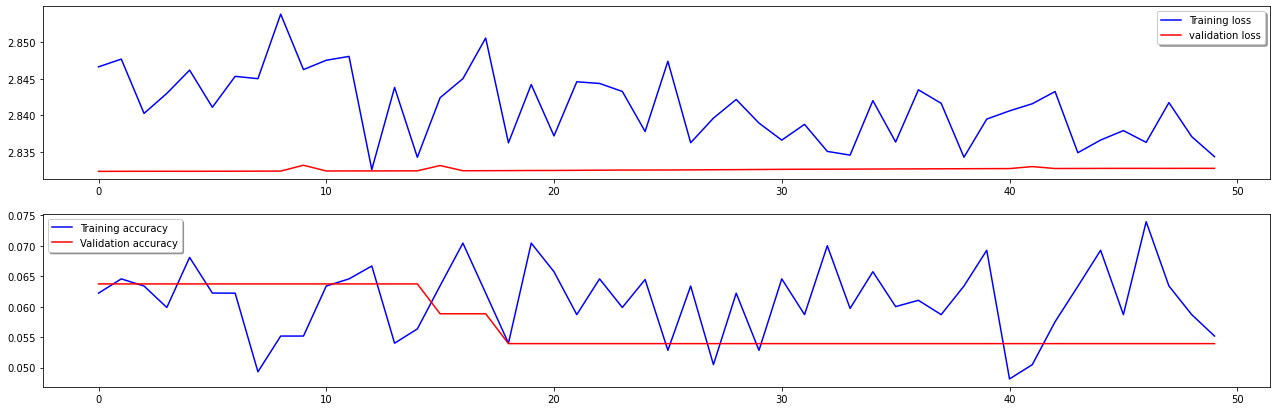

In [92]:
fig, ax = plt.subplots(2,1 , figsize=(22,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

NameError: ignored

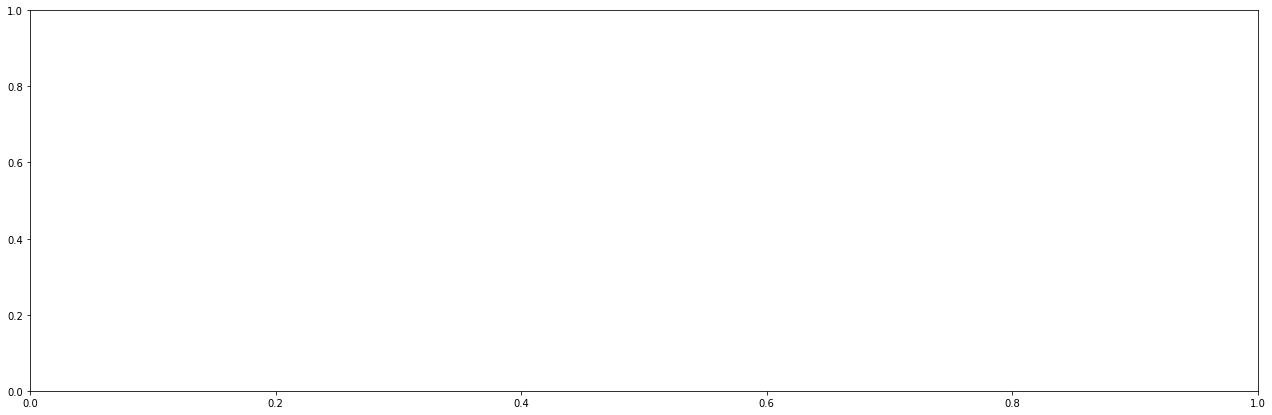

In [93]:
from sklearn.metrics import confusion_matrix
import itertools
plt.subplots(figsize=(22,7)) #set the size of the plot 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [94]:
cnn_predict_aug = np.argmax(cnn.predict(img_predict))

In [95]:
print('The predicted flower is with label:', cnn_predict)

The predicted flower is with label: 1
